=== Метрики для Бэггинга ===
Точность: 0.788136
Точность пол. класса: 0.775281
Полнота: 0.696970
Гармоническое среднее: 0.734043
Площадь под кривой ошибок: 0.775492

=== Метрики для Бустинга ===
Точность: 0.779661
Точность пол. класса: 0.752688
Полнота: 0.707071
Гармоническое среднее: 0.729167
Площадь под кривой ошибок: 0.769594


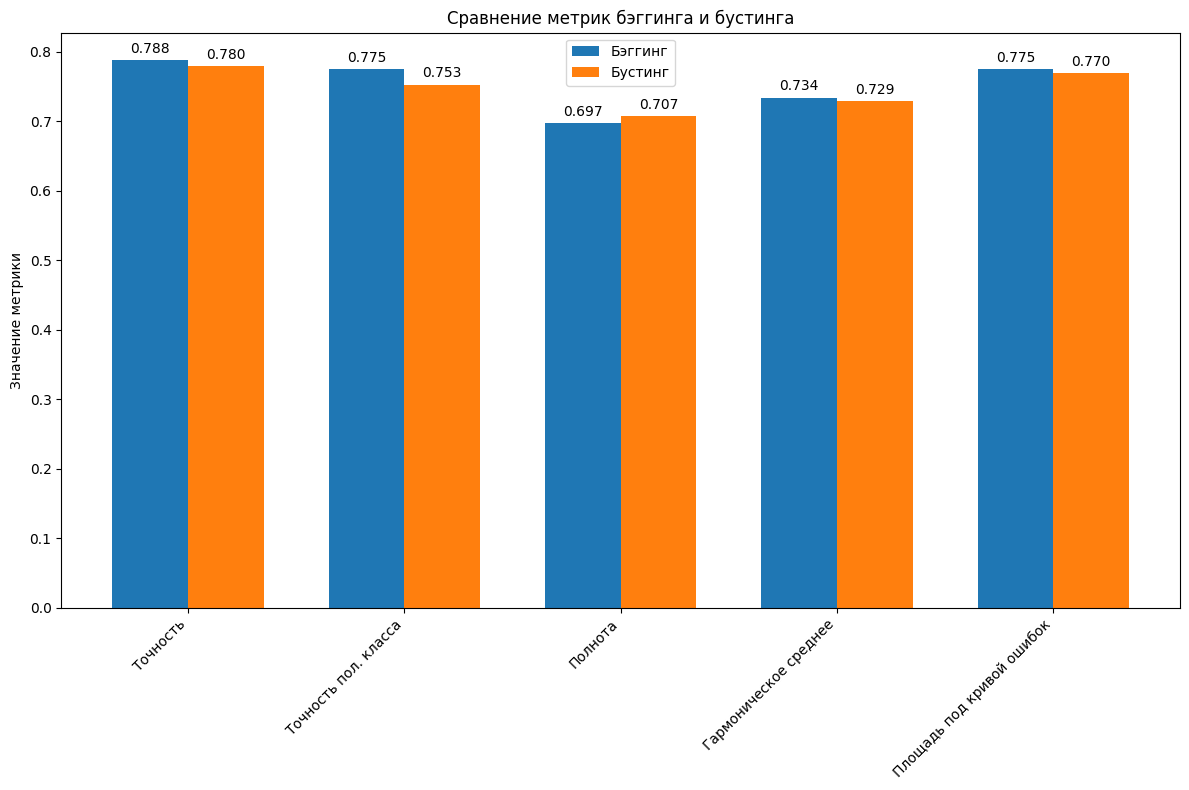

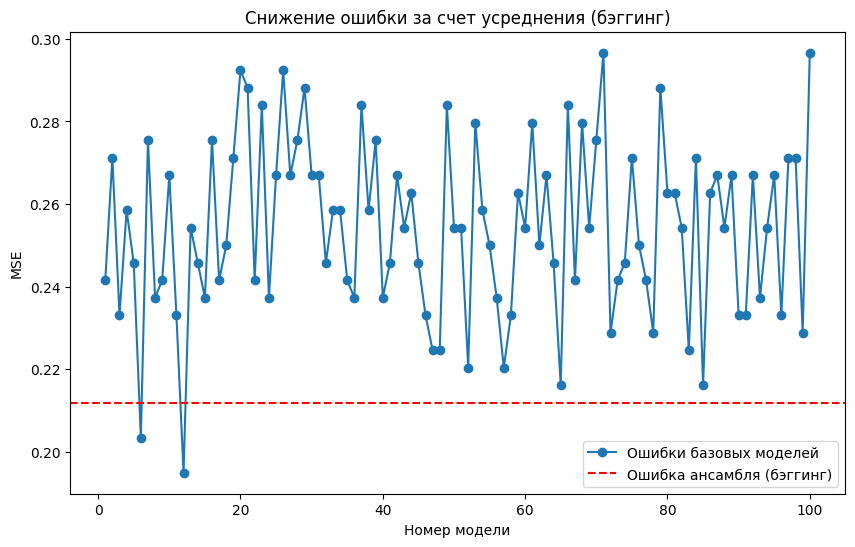

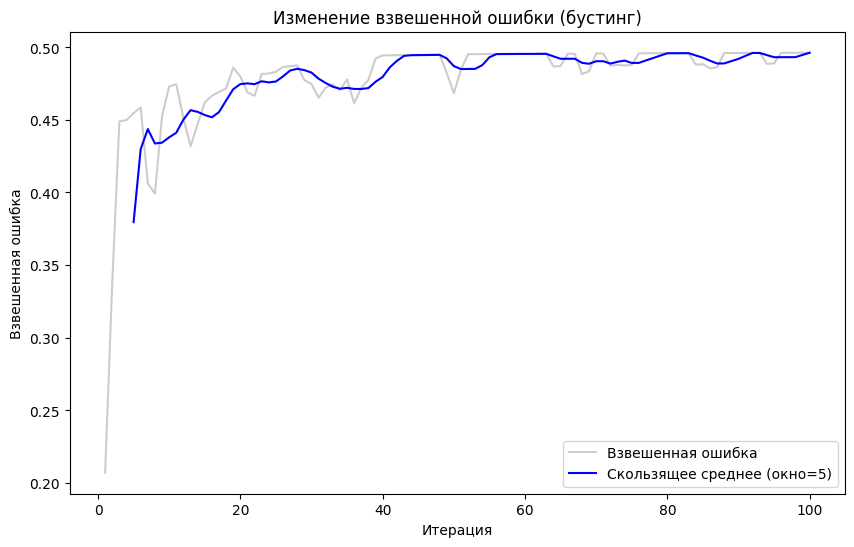


Бэггинг - MSE ансамбля: 0.211864
Бустинг - MSE: 0.220339


In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Загрузка данных
df = pd.read_csv('titanic.csv')
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].copy()
df.dropna(inplace=True)
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

# Разделение на признаки и целевую переменную
X = df.drop(columns=['Survived'])
Y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Размер ансамбля
n = 100

# Бэггинг
models_bag = []
pred_bag = []
for i in range(n):
    j = np.random.choice(len(x_train), size=len(x_train), replace=True)
    x = x_train.iloc[j]
    y = y_train.iloc[j]
    tree = DecisionTreeClassifier(max_depth=None, random_state=i)
    tree.fit(x, y)
    models_bag.append(tree)
    pred_bag.append(tree.predict(x_test))

pred_bag = np.array(pred_bag)
avg = np.mean(pred_bag, axis=0)
result_bag = (avg >= 0.5).astype(int)

# Метрики для бэггинга
mse_all = [mean_squared_error(y_test, pred) for pred in pred_bag]
mse_bag = mean_squared_error(y_test, result_bag)

# Бустинг
y_train_boost = y_train.replace({0: -1, 1: 1})
y_test_boost = y_test.replace({0: -1, 1: 1})

models_boost = []
alphas = []
errors = []
N = len(x_train)
weights = np.ones(N) / N

for m in range(n):
    tree = DecisionTreeClassifier(max_depth=1, random_state=m)
    tree.fit(x_train, y_train_boost, sample_weight=weights)
    pred = tree.predict(x_train)
    incorrect = (pred != y_train_boost)
    error = np.dot(weights, incorrect)

    if error == 0:
        error = 1e-10
    alpha = 0.5 * np.log((1 - error) / error)

    models_boost.append(tree)
    alphas.append(alpha)
    errors.append(error)

    weights = weights * np.exp(-alpha * y_train_boost * pred)
    weights /= np.sum(weights)

# Предсказание бустинга
sum_pred = np.zeros(len(x_test))
for alpha, tree in zip(alphas, models_boost):
    sum_pred += alpha * tree.predict(x_test)
result_boost = np.sign(sum_pred)
result_boost_bin = (result_boost == 1).astype(int)
y_test_bin = (y_test_boost == 1).astype(int)
mse_boost = mean_squared_error(y_test_bin, result_boost_bin)

# Функция для вычисления метрик
def compute_metrics(y_true, y_pred):
    metrics = {}
    metrics['Точность'] = accuracy_score(y_true, y_pred)
    metrics['Точность пол. класса'] = precision_score(y_true, y_pred)
    metrics['Полнота'] = recall_score(y_true, y_pred)
    metrics['Гармоническое среднее'] = f1_score(y_true, y_pred)
    metrics['Площадь под кривой ошибок'] = roc_auc_score(y_true, y_pred)
    return metrics

# Сравнение метрик
bag_metrics = compute_metrics(y_test, result_bag)
boost_metrics = compute_metrics(y_test_bin, result_boost_bin)

print("=== Метрики для Бэггинга ===")
for k, v in bag_metrics.items():
    print(f"{k}: {v:.6f}")
print("\n=== Метрики для Бустинга ===")
for k, v in boost_metrics.items():
    print(f"{k}: {v:.6f}")

# Визуализация метрик
labels = list(bag_metrics.keys())
bag_vals = list(bag_metrics.values())
boost_vals = list(boost_metrics.values())
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, bag_vals, width, label='Бэггинг')
rects2 = ax.bar(x + width/2, boost_vals, width, label='Бустинг')
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик бэггинга и бустинга')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

# График ошибок бэггинга
plt.figure(figsize=(10, 6))
plt.plot(range(1, n+1), mse_all, 'o-', label='Ошибки базовых моделей')
plt.axhline(y=mse_bag, color='r', linestyle='--', label='Ошибка ансамбля (бэггинг)')
plt.xlabel('Номер модели')
plt.ylabel('MSE')
plt.title('Снижение ошибки за счет усреднения (бэггинг)')
plt.legend()
plt.show()

# График ошибок бустинга
errors_series = pd.Series(errors)
window = 5
rolling_mean = errors_series.rolling(window=window).mean()

plt.figure(figsize=(10, 6))
plt.plot(range(1, n+1), errors, color='gray', alpha=0.4, label='Взвешенная ошибка')
plt.plot(range(1, n+1), rolling_mean, color='blue', label=f'Скользящее среднее (окно={window})')
plt.xlabel('Итерация')
plt.ylabel('Взвешенная ошибка')
plt.title('Изменение взвешенной ошибки (бустинг)')
plt.legend()
plt.show()

# Вывод ошибок
print(f"\nБэггинг - MSE ансамбля: {mse_bag:.6f}")
print(f"Бустинг - MSE: {mse_boost:.6f}")